In [1]:
import os
from glob import glob
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import numpy as np
from netCDF4 import Dataset
from scipy.io import loadmat

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)

w = cluster.start_workers(3)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.21:51366 Dashboard: http://10.148.1.21:8787/status,Cluster Workers: 6 Cores: 24 Memory: 300.00 GB


# Heat fluxes

In [30]:
# the path where (Zach's) LLC4320 data are already stored
LLC_data_folder = '/home1/datawork/xyu/OSMOSIS_llc4320/'
# the path where the data will be re-stored
out_dir_nc = '/home1/scratch/xyu/OSMOSIS_llc4320/nc_file/'

# variable 
#v = 'oceTAUY'

V = ['oceFWflx','oceQnet','oceQsw','oceSflux']


In [31]:
# store in netcdf files
fsize_bound = 5*1e6

for v in V:
        
    filenames = sorted(glob(LLC_data_folder+v+'/'+v+'_177x201.*')) 
    print('Number of files processed: %d' %len(filenames))

    for i in np.arange(len(filenames)):

        file_out = out_dir_nc+'/%s_t%05d.nc'%(v, i)
          
        if not os.path.isfile(file_out) or os.path.getsize(file_out) < fsize_bound:            
        
            ds = np.fromfile(filenames[i] , dtype='>f').reshape(201,177)
            ds = np.array(ds)
            ds = xr.DataArray(ds, dims=['lat','lon'])
            ds = np.real(ds).rename(v)
            ds = ds.load() # this may be required in order to prevent pickle related errors

        #
            while True:
                try:
                    ds.to_netcdf(file_out, mode='w', unlimited_dims=['time'])

                except:
                    print('failure')
                break

        else:
            print('t=%d - allready processed'%(i))

Number of files processed: 9415


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


Number of files processed: 9415
Number of files processed: 9415
Number of files processed: 9415


# 2. Add coordinates and put variables into one xarray file

In [33]:
v= 'oceFWflx'

out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'


filenames = sorted(glob(out_dir_nc+v+'_t*.nc')) 
print('Number of files processed: %d' %len(filenames))
%time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')
ds

Number of files processed: 9415


OSError: [Errno 24] Too many open files: b'/home1/scratch/xyu/OSMOSIS_llc4320/nc_file/oceFWflx_t00010.nc'

<xarray.DataArray 'oceSflux' (lat: 201, lon: 177)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Dimensions without coordinates: lat, lon

tornado.application - ERROR - Exception in callback <bound method SystemMonitor.update of <SystemMonitor: cpu: 2 memory: 11252 MB fds: 16384>>
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/tornado/ioloop.py", line 1208, in _run
    return self.callback()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/system_monitor.py", line 49, in update
    cpu = self.proc.cpu_percent()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/psutil/__init__.py", line 985, in cpu_percent
    pt2 = self._proc.cpu_times()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/psutil/_pslinux.py", line 1401, in wrapper
    return fun(self, *args, **kwargs)
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/psutil/_pslinux.py", line 1565, in cpu_times
    values = self._parse_stat_file()
  File "/home1/datahome/

In [32]:
V = ['oceFWflx','oceQnet','oceQsw','oceSflux']

out_dir_zarr = '/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/'

for v in V:
    
    filenames = sorted(glob(out_dir_nc+v+'_t*.nc')) 
    print('Number of files processed: %d' %len(filenames))
    %time ds = xr.open_mfdataset(filenames, concat_dim='time', compat='equals')
    ds = ds.assign_coords(time=np.arange(len(filenames))*3600/86400) 
    chunks = {'time': 9415, 'lat': 201, 'lon': 177}
    ds = ds.chunk(chunks)
    print(ds)
    file_out = out_dir_zarr+'/%s_total_rechunk.zarr'%(v)
    %time ds.to_zarr(file_out, mode='w')        

Number of files processed: 9415


OSError: [Errno 24] Too many open files: b'/home1/scratch/xyu/OSMOSIS_llc4320/nc_file/oceFWflx_t00009.nc'

ValueError: cannot add coordinates with new dimensions to a DataArray

# Read re-chunked data

In [21]:
v = 'oceFWflx'

In [22]:
ds = xr.open_zarr(out_dir_zarr+v+'_total_rechunk.zarr')
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

ValueError: group not found at path ''

CPU times: user 72 ms, sys: 24 ms, total: 96 ms
Wall time: 1.73 s


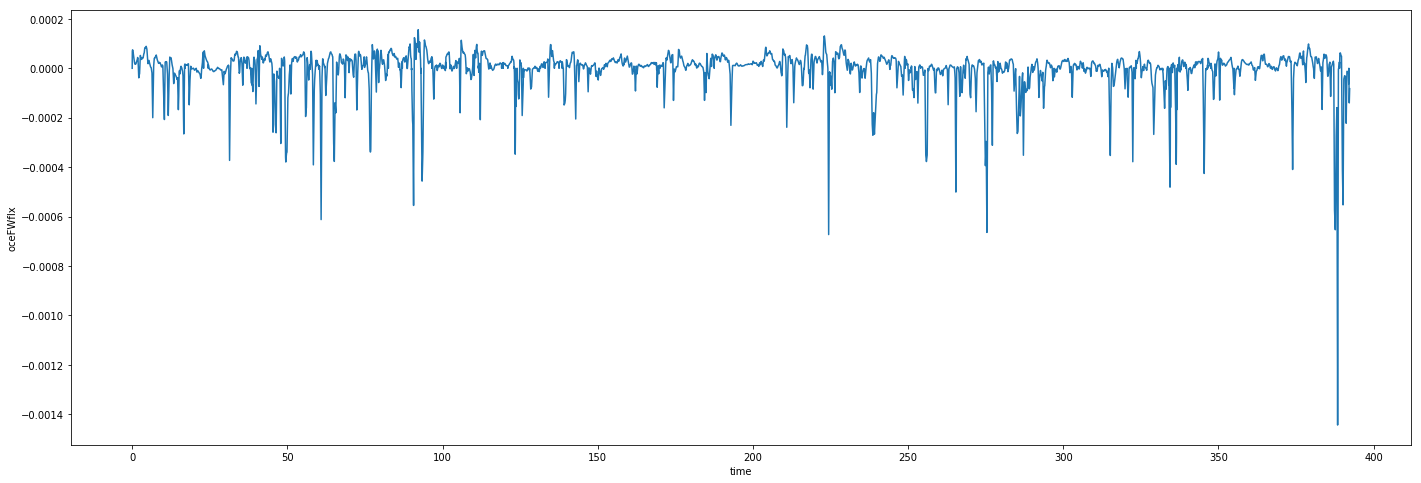

In [16]:
fig = plt.figure(figsize=(24,8))
%time ds[v].isel(lat=slice(90,100), lon=slice(90,100)).mean(dim=['lat','lon']).plot()

In [35]:
cluster.scheduler.close()

<Future finished result=None>